# Plik z skryptami i wytlumaczniami 

Ponieważ nasz plik pcap zawiera strumień pakietów UDP, ale nie metadane czujnika, najpierw ładujemy informacje o czujniku z metadata_path, używając modułu klienta:

In [6]:
metadata_path = "C:/Users/szyme/Ouster/data/PKR_test1/test4.json"
pcap_path = "C:/Users/szyme/Ouster/data/PKR_test1/test4.pcap"

from ouster import client
import numpy as np

with open(metadata_path, 'r') as f:
    metadata = client.SensorInfo(f.read())

Teraz, gdy przetworzyliśmy plik metadanych na `SensorInfo`, możemy użyć go do odczytania naszych przechwyconych danych UDP poprzez instancję `pcap.Pcap`. Klasa ta działa jak `PacketSource` i może być używana w wielu takich samych kontekstach jak prawdziwy sensor. Bezpośrednia praca z pakietami może być korzystna, gdy chodzi o opóźnienia lub gdy chcesz sprawdzić pakiet danych po pakiecie, np. jeśli chcesz sprawdzić znaczniki czasu pakietów.

In [7]:
from ouster import pcap

source = pcap.Pcap(pcap_path, metadata, lidar_port=7502)

  acceleration = [0.05102539 0.02075195 1.01171875]
  angular_velocity = [ 2.48718262 -0.96130371  0.85449219]
  acceleration = [0.03173828 0.04736328 1.01464844]
  angular_velocity = [1.19781494 1.26647949 0.54931641]
  acceleration = [-0.05273438  0.03686523  0.99023438]
  angular_velocity = [0.33569336 1.43432617 0.11444092]
  acceleration = [-0.03051758  0.00805664  0.98461914]
  angular_velocity = [ 1.43432617 -1.2588501   0.61035156]


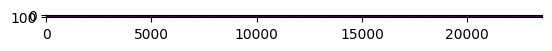

In [8]:
from contextlib import closing
from more_itertools import nth
import matplotlib.pyplot as plt

i = 0
j = 0
velocity = 0
frame = np.ones((128, 1))
# print(frame)

i = 0
for packet in source:
    i += 1
    if isinstance(packet, client.LidarPacket):
        measurement_ids = packet.measurement_id
        if measurement_ids[-1] == 1023:
            frame = np.concatenate((frame[:,1:], ranges), axis=1)
            break
        frame = np.concatenate((frame, ranges), axis=1)
    elif isinstance(packet, client.ImuPacket):
        print(f'  acceleration = {packet.accel}') # przyspieszenie
        print(f'  angular_velocity = {packet.angular_vel}') # predkosc katowa

ranges_destaggered = client.destagger(source.metadata, frame)

plt.imshow(ranges_destaggered)

Teraz możemy odczytać pakiety (`LidarPacket` i `ImuPacket`) ze źródła za pomocą następującego kodu:

In [9]:
i = 0
for packet in source:
    i += 1
    if isinstance(packet, client.LidarPacket):
        measurement_ids = packet.measurement_id
        timestamps = packet.timestamp
        ranges = packet.field(client.ChanField.RANGE)
        print(f'  encoder counts = {measurement_ids.shape}')
        print(f'  timestamps = {timestamps.shape}')
        print(f'  ranges = {ranges.shape}')

    elif isinstance(packet, client.ImuPacket):
        print(f'  acceleration = {packet.accel}') # przyspieszenie
        print(f'  angular_velocity = {packet.angular_vel}') # predkosc katowa

    if i >= 1:
        break

  encoder counts = (16,)
  timestamps = (16,)
  ranges = (128, 16)


# `LidarScan`

Klasa `LidarScan` grupuje pakiety lidarowe poprzez pełny obrót do dostępnych pól odpowiedniego typu. `LidarScan` pozwala również na łatwe rzutowanie zgrupowanych danych na współrzędne kartezjańskie, tworząc chmury punktów.

In [10]:
import matplotlib.pyplot as plt
from more_itertools import nth

scans = client.Scans(source)
scan = nth(scans, 600) # specific frame

print("Available fields and corresponding dtype in LidarScan")
for field in scan.fields:
    print('{0:15} {1}'.format(str(field), scan.field(field).dtype))

# with closing(client.Scans(source)) as scans:
#     for scan in scans:
#         sig_field = scan.field(client.ChanField.SIGNAL)

Available fields and corresponding dtype in LidarScan
RANGE           uint32
SIGNAL          uint32
NEAR_IR         uint32
REFLECTIVITY    uint32


# Projecting into Cartesian Coordinates
Aby ułatwić pracę z punktami 3D, można utworzyć wstępnie obliczoną look-up-table `XYZLut` (`client.XYZLut()`) na odpowiednich metadanych, której można następnie użyć do wydajnego rzutowania pól `RANGE` i `RANGE2` na współrzędne kartezjańskie. Wynikiem wywołania tej funkcji będzie chmura punktów reprezentowana jako tablica (`numpy`).

In [11]:
xyzlut = client.XYZLut(metadata)
ranges = scan.field(client.ChanField.RANGE)
xyz = xyzlut(scan)

Domyślna reprezentacja `LidarScan` przechowuje dane w naprzemiennych (**staggered**) kolumnach, co oznacza, że każda kolumna zawiera pomiary wykonane w jednym punkcie czasowym. Ponieważ lasery migające w każdym punkcie czasowym są rozmieszczone na kilku różnych azymutach, wynikowy obraz 2D, jeśli jest bezpośrednio wizualizowany, nie jest obrazem naturalnym.

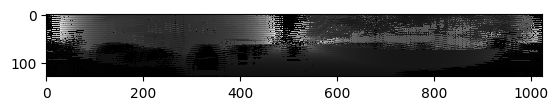

In [12]:
plt.imshow(ranges.astype(np.uint16), cmap='gray', resample=False)

wygodnie byłoby uzyskać reprezentację, w której kolumny reprezentują kąt azymutu zamiast czasu. Dla tego naturalnego obrazu 2D, **destaggerujemy** odpowiednie pole `LidarScan` za pomocą `destagger` (funkcja `client.destagger()`):

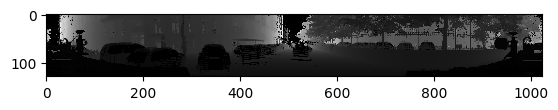

In [13]:
ranges_destaggered = client.destagger(source.metadata, ranges)
plt.imshow(ranges_destaggered.astype(np.uint16), cmap='gray', resample=False)

# Working with 2D and 3D Representations Simultaneously

Bezpośrednia korelacja między reprezentacjami 2D i 3D w czujniku Ouster zapewnia potężne środowisko do pracy z danymi. Łatwym przykładem może być decyzja, że chcesz przyjrzeć się tylko punktom 3D w określonym zakresie i pod określonymi kątami azymutu.

In [14]:
import math 

range_destaggered = client.destagger(metadata,
                                     ranges)

# obtain destaggered xyz representation
xyzlut = client.XYZLut(metadata)
xyz_destaggered = client.destagger(metadata, xyzlut(scan))

range_min = 2
# select only points with more than min range using the range data
xyz_filtered = xyz_destaggered * (range_destaggered[:, :, np.newaxis] >
                                  (range_min * 1000))

# get first 3/4 of scan
to_col = math.floor(metadata.mode.cols * 3 / 4)
xyz_filtered = xyz_filtered[:, 0:to_col, :]

Ponieważ chcemy filtrować na podstawie kątów azymutu, najpierw **destagujemy** zarówno punkty 2D, jak i 3D, tak aby nasze kolumny w reprezentacji `HxW` odpowiadały kątowi azymutu, a nie czasowi.

Następnie filtrujemy punkty 3D `xyz_destaggered`, porównując pomiar zasięgu z `range_min`, co możemy zrobić, ponieważ istnieje zgodność 1:1 między kolumnami i wierszami rozłożonych reprezentacji `xyz_destaggered` i `range_destaggered`.

Na koniec wybieramy tylko interesujące nas kolumny azymutu. W tym przypadku arbitralnie wybraliśmy pierwsze 270 stopni obrotu.

# wizualizacja z terminala

In [15]:
# ouster-cli source "C:/Users/szyme/Ouster/data/PKR_test1/test1.pcap" viz

import open3d as o3d
# compute point cloud using client.SensorInfo and client.LidarScan
xyz = client.XYZLut(metadata)(scan)

# create point cloud and coordinate axes geometries

cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz.reshape((-1, 3))))  # type: ignore

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(1.0)  # type: ignore

ModuleNotFoundError: No module named 'open3d'

### matplotlib 2D

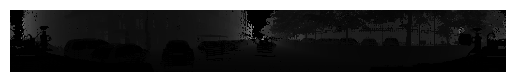

In [16]:
range_field = scan.field(client.ChanField.RANGE)
range_img = client.destagger(source.metadata, range_field)

plt.imshow(range_img[:, 0:1024], resample=False, cmap='gray')
plt.axis('off')
plt.show()

### matplotlib 3D

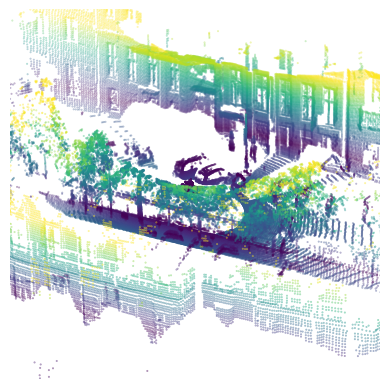

In [17]:
xyzlut = client.XYZLut(metadata)
xyz = xyzlut(scan)

[x, y, z] = [c.flatten() for c in np.dsplit(xyz, 3)]
ax = plt.axes(projection='3d')
r = 10
ax.set_xlim3d([-r, r])
ax.set_ylim3d([-r, r])
ax.set_zlim3d([-r/2, r/2])
plt.axis('off')
z_col = np.minimum(np.absolute(z), 5)
ax.scatter(x, y, z, c=z_col, s=0.2)
plt.show()

# Converting pcap to other formats:

https://static.ouster.dev/sdk-docs/python/examples/conversion.html

# Point Cloud Visualizer

`viz.PointViz` jest głównym punktem wejścia do wizualizatora Ouster i śledzi stan okna, uruchamia główną pętlę wizualizacji oraz obsługuje zdarzenia myszy i klawiatury.

Aby utworzyć okno `PointViz`, możesz spróbować wykonać następujące czynności:

In [18]:
from ouster.sdk import viz

# Creating a point viz instance
point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

point_viz.update()
point_viz.run()

ImportError: cannot import name 'viz' from 'ouster.sdk' (c:\Users\szyme\Ouster\YOLOv8\.venv\lib\site-packages\ouster\sdk\__init__.py)

## Images and Labels

Aby utworzyć obraz 2D, należy użyć obiektu `viz.Image`. Obecnie obsługiwane są tylko znormalizowane obrazy w skali szarości, ale można użyć `viz.Image.set_mask()`, który akceptuje maski RGBA, aby uzyskać kolor.

Układ współrzędnych ekranu `viz.Image` jest znormalizowany pod względem wysokości i przebiega od dołu do góry ([-1, +1]) dla współrzędnej y oraz od lewej do prawej ([-aspect, +aspect]) dla współrzędnej x, gdzie:

`aspect = viewport width in Pixels / viewport height in Pixels`

In [19]:
point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

img = viz.Image()
img.set_image(np.full((10, 10), 0.5))
img.set_position(-0.5, 0.5, -0.5, 0.5)
point_viz.add(img)

point_viz.update()
point_viz.run()

NameError: name 'viz' is not defined

Aby wyrównać obraz do lewej lub prawej krawędzi ekranu, należy użyć funkcji `viz.Image.set_hshift()`, która akceptuje przesunięcie poziome o znormalizowanej szerokości ([-1, 1]), które jest stosowane do pozycji obrazu po pierwszym zastosowaniu wartości `viz.Image.set_position()`.

In [ ]:
point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

img = viz.Image()
img.set_image(np.full((10, 10), 0.5))
img.set_position(-0.5, 0.5, -0.5, 0.5)
# img.set_position(0, 1, -0.5, 0.5)
img.set_hshift(-1)

point_viz.add(img)

point_viz.update()
point_viz.run()

## LidarScan Fields as Images

Teraz możemy użyć `viz.Image` do wizualizacji danych pól `LidarScan` jako obrazów. W tym przykładzie pokazujemy obrazy pól RANGE i SIGNAL umieszczone odpowiednio na górze i na dole ekranu.

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)


img_aspect = (metadata.beam_altitude_angles[0] -
              metadata.beam_altitude_angles[-1]) / 360.0
img_screen_height = 0.4  # [0..2]
img_screen_len = img_screen_height / img_aspect

scaling_factor = 0.003
ranges = scan.field(client.ChanField.RANGE)
ranges_destaggered = client.destagger(metadata, ranges)
# ranges = ranges_destaggered / (200+scaling_factor * ranges_destaggered)
# ranges = ranges_destaggered.astype(np.uint8)
ranges = np.divide(ranges_destaggered, np.amax(ranges), dtype=np.float32)

scaling_factor = 0.004
signal = scan.field(client.ChanField.SIGNAL)
signal_destaggered = client.destagger(metadata, signal)
signal = signal_destaggered / (0.5+scaling_factor * signal_destaggered)
signal = signal.astype(np.uint8)
signal = np.divide(signal, np.amax(signal))

# creating Image viz element
range_img = viz.Image()
range_img.set_image(ranges)
range_img.set_position(-img_screen_len / 2, img_screen_len / 2,
                       1 - img_screen_height, 1)
point_viz.add(range_img)

range_label = viz.Label(str(client.ChanField.RANGE), 0.5, 0, align_top=True)
range_label.set_scale(1)
point_viz.add(range_label)

signal_img = viz.Image()
signal_img.set_image(signal)
img_aspect = (metadata.beam_altitude_angles[0] -
              metadata.beam_altitude_angles[-1]) / 360.0
img_screen_height = 0.4  # [0..2]
img_screen_len = img_screen_height / img_aspect
# bottom center position
signal_img.set_position(-img_screen_len / 2, img_screen_len / 2, -1,
                        -1 + img_screen_height)
point_viz.add(signal_img)

signal_label = viz.Label(str(client.ChanField.SIGNAL), 0.5, 1 - img_screen_height / 2, align_top=True)
signal_label.set_scale(1)
point_viz.add(signal_label)


point_viz.update()
point_viz.run()

ImportError: cannot import name 'viz' from 'ouster.sdk' (c:\Users\szyme\Ouster\YOLOv8\.venv\lib\site-packages\ouster\sdk\__init__.py)

## Point Clouds: the `Cloud` object

Wizualizacja chmury punktów zaimplementowana za pomocą obiektu `viz.Cloud` może być używana na dwa sposoby:
- `Structured Point Clouds`, gdzie punkty 3D są definiowane za pomocą obrazów pól 2D (tj. obrazów pól `LidarScan`)
- Niestrukturalne chmury punktów, w których punkty 3D są definiowane bezpośrednio jako zestaw punktów XYZ.

### Structured Point Cloud

Czujnik Ouster generuje ustrukturyzowaną chmurę punktów jako obraz zasięgu 2D, który można rzutować na współrzędne kartezjańskie 3D za pomocą wstępnie wygenerowanej look-up table. Z tego powodu wewnętrzna implementacja `viz.Cloud` stosuje transformację look-up table automatycznie generowaną z `client.SensorInfo` (obiekt metadanych) i obraz 2D RANGE jako dane wejściowe.

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)


img_aspect = (metadata.beam_altitude_angles[0] -
              metadata.beam_altitude_angles[-1]) / 360.0
img_screen_height = 0.4  # [0..2]
img_screen_len = img_screen_height / img_aspect

scaling_factor = 0.003
ranges = scan.field(client.ChanField.RANGE)
ranges_destaggered = client.destagger(metadata, ranges)
# ranges = ranges_destaggered / (200+scaling_factor * ranges_destaggered)
# ranges = ranges_destaggered.astype(np.uint8)
ranges = np.divide(ranges_destaggered, np.amax(ranges), dtype=np.float32)

scaling_factor = 0.004
signal = scan.field(client.ChanField.SIGNAL)
signal_destaggered = client.destagger(metadata, signal)
signal = signal_destaggered / (0.5+scaling_factor * signal_destaggered)
signal = signal.astype(np.uint8)
signal = np.divide(signal, np.amax(signal))

# creating Image viz element
range_img = viz.Image()
range_img.set_image(ranges)
range_img.set_position(-img_screen_len / 2, img_screen_len / 2,
                       1 - img_screen_height, 1)
point_viz.add(range_img)

range_label = viz.Label(str(client.ChanField.RANGE), 0.5, 0, align_top=True)
range_label.set_scale(1)
point_viz.add(range_label)

signal_img = viz.Image()
signal_img.set_image(signal)
signal_img.set_position(-img_screen_len / 2, img_screen_len / 2, -1,
                        -1 + img_screen_height)
point_viz.add(signal_img)

signal_label = viz.Label(str(client.ChanField.SIGNAL), 0.5, 1 - img_screen_height / 2, align_top=True)
signal_label.set_scale(1)
point_viz.add(signal_label)

#########################################
cloud_scan = viz.Cloud(metadata)
cloud_scan.set_range(scan.field(client.ChanField.RANGE))
cloud_scan.set_key(signal)
point_viz.add(cloud_scan)
########################################

point_viz.update()
point_viz.run()

### Unstructured Point Clouds

Chmury punktów, które są reprezentowane jako zestaw punktów XYZ 3D, nazywane są dla naszych celów niestrukturalnymi.

Możliwe jest ustawienie obiektu `viz.Cloud` poprzez bezpośrednie ustawienie punktów 3D, co jest przydatne w przypadku nieuporządkowanych chmur punktów.

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)


img_aspect = (metadata.beam_altitude_angles[0] -
              metadata.beam_altitude_angles[-1]) / 360.0
img_screen_height = 0.4  # [0..2]
img_screen_len = img_screen_height / img_aspect

scaling_factor = 0.003
ranges = scan.field(client.ChanField.RANGE)
ranges_destaggered = client.destagger(metadata, ranges)
# ranges = ranges_destaggered / (200+scaling_factor * ranges_destaggered)
# ranges = ranges_destaggered.astype(np.uint8)
ranges = np.divide(ranges_destaggered, np.amax(ranges), dtype=np.float32)

scaling_factor = 0.004
signal = scan.field(client.ChanField.SIGNAL)
signal_destaggered = client.destagger(metadata, signal)
signal = signal_destaggered / (0.5+scaling_factor * signal_destaggered)
signal = signal.astype(np.uint8)
signal = np.divide(signal, np.amax(signal))

# creating Image viz element
range_img = viz.Image()
range_img.set_image(ranges)
range_img.set_position(-img_screen_len / 2, img_screen_len / 2,
                       1 - img_screen_height, 1)
point_viz.add(range_img)

range_label = viz.Label(str(client.ChanField.RANGE), 0.5, 0, align_top=True)
range_label.set_scale(1)
point_viz.add(range_label)

signal_img = viz.Image()
signal_img.set_image(signal)
signal_img.set_position(-img_screen_len / 2, img_screen_len / 2, -1,
                        -1 + img_screen_height)
point_viz.add(signal_img)

signal_label = viz.Label(str(client.ChanField.SIGNAL), 0.5, 1 - img_screen_height / 2, align_top=True)
signal_label.set_scale(1)
point_viz.add(signal_label)

#########################################
# transform scan data to 3d points
xyzlut = client.XYZLut(metadata)
xyz = xyzlut(scan.field(client.ChanField.RANGE))

cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))
cloud_xyz.set_key(signal.ravel())
point_viz.add(cloud_xyz)
########################################

point_viz.update()
point_viz.run()

### 3D Axes Helper as Unstructured Points

Obiekt `viz.Cloud` obsługuje również kolorowe maski RGBA. Poniżej znajduje się przykład wykorzystania nieuporządkowanych chmur punktów do rysowania osi 3D w punkcie początkowym:

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)


img_aspect = (metadata.beam_altitude_angles[0] -
              metadata.beam_altitude_angles[-1]) / 360.0
img_screen_height = 0.4  # [0..2]
img_screen_len = img_screen_height / img_aspect

scaling_factor = 0.003
ranges = scan.field(client.ChanField.RANGE)
ranges_destaggered = client.destagger(metadata, ranges)
# ranges = ranges_destaggered / (200+scaling_factor * ranges_destaggered)
# ranges = ranges_destaggered.astype(np.uint8)
ranges = np.divide(ranges_destaggered, np.amax(ranges), dtype=np.float32)

scaling_factor = 0.004
signal = scan.field(client.ChanField.SIGNAL)
signal_destaggered = client.destagger(metadata, signal)
signal = signal_destaggered / (0.5+scaling_factor * signal_destaggered)
signal = signal.astype(np.uint8)
signal = np.divide(signal, np.amax(signal))

# creating Image viz element
range_img = viz.Image()
range_img.set_image(ranges)
range_img.set_position(-img_screen_len / 2, img_screen_len / 2,
                       1 - img_screen_height, 1)
point_viz.add(range_img)

range_label = viz.Label(str(client.ChanField.RANGE), 0.5, 0, align_top=True)
range_label.set_scale(1)
point_viz.add(range_label)

signal_img = viz.Image()
signal_img.set_image(signal)
signal_img.set_position(-img_screen_len / 2, img_screen_len / 2, -1,
                        -1 + img_screen_height)
point_viz.add(signal_img)

signal_label = viz.Label(str(client.ChanField.SIGNAL), 0.5, 1 - img_screen_height / 2, align_top=True)
signal_label.set_scale(1)
point_viz.add(signal_label)

# transform scan data to 3d points
xyzlut = client.XYZLut(metadata)
xyz = xyzlut(scan.field(client.ChanField.RANGE))

cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))
cloud_xyz.set_key(signal.ravel())
point_viz.add(cloud_xyz)

########################################################
# basis vectors
x_ = np.array([1, 0, 0]).reshape((-1, 1))
y_ = np.array([0, 1, 0]).reshape((-1, 1))
z_ = np.array([0, 0, 1]).reshape((-1, 1))

axis_n = 100
line = np.linspace(0, 1, axis_n).reshape((1, -1))

# basis vector to point cloud
axis_points = np.hstack((x_ @ line, y_ @ line, z_ @ line)).transpose()

# colors for basis vectors
axis_color_mask = np.vstack((np.full(
    (axis_n, 4), [1, 0.1, 0.1, 1]), np.full((axis_n, 4), [0.1, 1, 0.1, 1]),
                             np.full((axis_n, 4), [0.1, 0.1, 1, 1])))

cloud_axis = viz.Cloud(axis_points.shape[0])
cloud_axis.set_xyz(axis_points)
cloud_axis.set_key(np.full(axis_points.shape[0], 0.5))
cloud_axis.set_mask(axis_color_mask)
cloud_axis.set_point_size(3)
point_viz.add(cloud_axis)
########################################################

point_viz.update()
point_viz.run()

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

img_aspect = (metadata.beam_altitude_angles[0] -
            metadata.beam_altitude_angles[-1]) / 360.0
img_screen_height = 0.4  # [0..2]
img_screen_len = img_screen_height / img_aspect

scaling_factor = 0.003
ranges = scan.field(client.ChanField.RANGE)
ranges_destaggered = client.destagger(metadata, ranges)
# ranges = ranges_destaggered / (200+scaling_factor * ranges_destaggered)
# ranges = ranges_destaggered.astype(np.uint8)
ranges = np.divide(ranges_destaggered, np.amax(ranges), dtype=np.float32)

scaling_factor = 0.004
signal = scan.field(client.ChanField.SIGNAL)
signal_destaggered = client.destagger(metadata, signal)
signal = signal_destaggered / (0.5+scaling_factor * signal_destaggered)
signal = signal.astype(np.uint8)
signal = np.divide(signal, np.amax(signal))

# creating Image viz element
range_img = viz.Image()
range_img.set_image(ranges)
range_img.set_position(-img_screen_len / 2, img_screen_len / 2,
                    1 - img_screen_height, 1)
point_viz.add(range_img)

range_label = viz.Label(str(client.ChanField.RANGE), 0.5, 0, align_top=True)
range_label.set_scale(1)
point_viz.add(range_label)

signal_img = viz.Image()
signal_img.set_image(signal)
signal_img.set_position(-img_screen_len / 2, img_screen_len / 2, -1,
                        -1 + img_screen_height)
point_viz.add(signal_img)

signal_label = viz.Label(str(client.ChanField.SIGNAL), 0.5, 1 - img_screen_height / 2, align_top=True)
signal_label.set_scale(1)
point_viz.add(signal_label)

# transform scan data to 3d points
xyzlut = client.XYZLut(metadata)
xyz = xyzlut(scan.field(client.ChanField.RANGE))

cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))
cloud_xyz.set_key(signal.ravel())
point_viz.add(cloud_xyz)

########################################################
# basis vectors
x_ = np.array([1, 0, 0]).reshape((-1, 1))
y_ = np.array([0, 1, 0]).reshape((-1, 1))
z_ = np.array([0, 0, 1]).reshape((-1, 1))

axis_n = 100
line = np.linspace(0, 1, axis_n).reshape((1, -1))

# basis vector to point cloud
axis_points = np.hstack((x_ @ line, y_ @ line, z_ @ line)).transpose()

# colors for basis vectors
axis_color_mask = np.vstack((np.full(
    (axis_n, 4), [1, 0.1, 0.1, 1]), np.full((axis_n, 4), [0.1, 1, 0.1, 1]),
                            np.full((axis_n, 4), [0.1, 0.1, 1, 1])))

cloud_axis = viz.Cloud(axis_points.shape[0])
cloud_axis.set_xyz(axis_points)
cloud_axis.set_key(np.full(axis_points.shape[0], 0.5))
cloud_axis.set_mask(axis_color_mask)
cloud_axis.set_point_size(3)
point_viz.add(cloud_axis)
########################################################

point_viz.update()
point_viz.run()

for scan in scans:
    img_aspect = (metadata.beam_altitude_angles[0] -
                metadata.beam_altitude_angles[-1]) / 360.0
    img_screen_height = 0.4  # [0..2]
    img_screen_len = img_screen_height / img_aspect

    scaling_factor = 0.003
    ranges = scan.field(client.ChanField.RANGE)
    ranges_destaggered = client.destagger(metadata, ranges)
    # ranges = ranges_destaggered / (200+scaling_factor * ranges_destaggered)
    # ranges = ranges_destaggered.astype(np.uint8)
    ranges = np.divide(ranges_destaggered, np.amax(ranges), dtype=np.float32)

    scaling_factor = 0.004
    signal = scan.field(client.ChanField.SIGNAL)
    signal_destaggered = client.destagger(metadata, signal)
    signal = signal_destaggered / (0.5+scaling_factor * signal_destaggered)
    signal = signal.astype(np.uint8)
    signal = np.divide(signal, np.amax(signal))

    # creating Image viz element
    range_img = viz.Image()
    range_img.set_image(ranges)
    range_img.set_position(-img_screen_len / 2, img_screen_len / 2,
                        1 - img_screen_height, 1)
    point_viz.add(range_img)

    range_label = viz.Label(str(client.ChanField.RANGE), 0.5, 0, align_top=True)
    range_label.set_scale(1)
    point_viz.add(range_label)

    signal_img = viz.Image()
    signal_img.set_image(signal)
    signal_img.set_position(-img_screen_len / 2, img_screen_len / 2, -1,
                            -1 + img_screen_height)
    point_viz.add(signal_img)

    signal_label = viz.Label(str(client.ChanField.SIGNAL), 0.5, 1 - img_screen_height / 2, align_top=True)
    signal_label.set_scale(1)
    point_viz.add(signal_label)

    # transform scan data to 3d points
    xyzlut = client.XYZLut(metadata)
    xyz = xyzlut(scan.field(client.ChanField.RANGE))

    cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
    cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))
    cloud_xyz.set_key(signal.ravel())
    point_viz.add(cloud_xyz)

    ########################################################
    # basis vectors
    x_ = np.array([1, 0, 0]).reshape((-1, 1))
    y_ = np.array([0, 1, 0]).reshape((-1, 1))
    z_ = np.array([0, 0, 1]).reshape((-1, 1))

    axis_n = 100
    line = np.linspace(0, 1, axis_n).reshape((1, -1))

    # basis vector to point cloud
    axis_points = np.hstack((x_ @ line, y_ @ line, z_ @ line)).transpose()

    # colors for basis vectors
    axis_color_mask = np.vstack((np.full(
        (axis_n, 4), [1, 0.1, 0.1, 1]), np.full((axis_n, 4), [0.1, 1, 0.1, 1]),
                                np.full((axis_n, 4), [0.1, 0.1, 1, 1])))

    cloud_axis = viz.Cloud(axis_points.shape[0])
    cloud_axis.set_xyz(axis_points)
    cloud_axis.set_key(np.full(axis_points.shape[0], 0.5))
    cloud_axis.set_mask(axis_color_mask)
    cloud_axis.set_point_size(3)
    point_viz.add(cloud_axis)
    ########################################################

    point_viz.update()

: 

### `LidarScanViz` for point cloud with fields images

Aby jeszcze bardziej ułatwić eksplorację danych obiektów `client.LidarScan`, udostępniamy komponent wizualny wyższego rzędu `viz.LidarScanViz`, który umożliwia:
- Chmura punktów 3D i dwa obrazy pól 2D w jednym widoku
- palety kolorów do kolorowania chmury punktów 3D
- zwiększanie/zmniejszanie rozmiaru chmury punktów
- przełączniki do wyświetlania obrazów różnych pól oraz zwiększania/zmniejszania ich rozmiaru
- obsługa podwójnych zwrotnych chmur punktów i obrazów pól
- obsługa kluczy dla wszystkich powyższych

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

# Creating LidarScan visualizer (3D point cloud + field images on top)
ls_viz = viz.LidarScanViz(metadata, point_viz)

# adding scan to the lidar scan viz
ls_viz.scan = scan

# refresh viz data
ls_viz.draw()

# visualize
# update() is not needed for LidatScanViz because it's doing it internally
point_viz.run()

Press '?' while viz window is focused to print key bindings


### 3D Label object

Ten sam obiekt `viz.Label`, którego używaliśmy do etykiet 2D, może być używany do umieszczania etykiet tekstowych w przestrzeni 3D.

In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

# Creating LidarScan visualizer (3D point cloud + field images on top)
ls_viz = viz.LidarScanViz(metadata, point_viz)

# adding scan to the lidar scan viz
ls_viz.scan = scan

# refresh viz data
ls_viz.draw()

########################################################
# basis vectors
x_ = np.array([1, 0, 0]).reshape((-1, 1))
y_ = np.array([0, 1, 0]).reshape((-1, 1))
z_ = np.array([0, 0, 1]).reshape((-1, 1))

axis_n = 100
line = np.linspace(0, 1, axis_n).reshape((1, -1))

# basis vector to point cloud
axis_points = np.hstack((x_ @ line, y_ @ line, z_ @ line)).transpose()

# colors for basis vectors
axis_color_mask = np.vstack((np.full(
    (axis_n, 4), [1, 0.1, 0.1, 1]), np.full((axis_n, 4), [0.1, 1, 0.1, 1]),
                             np.full((axis_n, 4), [0.1, 0.1, 1, 1])))

cloud_axis = viz.Cloud(axis_points.shape[0])
cloud_axis.set_xyz(axis_points)
cloud_axis.set_key(np.full(axis_points.shape[0], 0.5))
cloud_axis.set_mask(axis_color_mask)
cloud_axis.set_point_size(3)
point_viz.add(cloud_axis)
########################################################


# Adding 3D Labels
label1 = viz.Label("Label1: [0, 4, 0]", 0, 4, 0)
point_viz.add(label1)

label2 = viz.Label("Label2: [0, 0, 4]", 0, 0, 4)
label2.set_scale(2)
point_viz.add(label2)

label3 = viz.Label("Label3: [4, 0, 0]", 4, 0, 0)
label3.set_scale(3)
point_viz.add(label3)

# visualize
# update() is not needed for LidatScanViz because it's doing it internally
point_viz.run()

Press '?' while viz window is focused to print key bindings


In [ ]:
from ouster.sdk import viz

point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

# Creating LidarScan visualizer (3D point cloud + field images on top)
ls_viz = viz.LidarScanViz(metadata, point_viz)

# adding scan to the lidar scan viz
ls_viz.scan = scan

# refresh viz data
ls_viz.draw()

########################################################
# basis vectors
x_ = np.array([1, 0, 0]).reshape((-1, 1))
y_ = np.array([0, 1, 0]).reshape((-1, 1))
z_ = np.array([0, 0, 1]).reshape((-1, 1))

axis_n = 100
line = np.linspace(0, 1, axis_n).reshape((1, -1))

# basis vector to point cloud
axis_points = np.hstack((x_ @ line, y_ @ line, z_ @ line)).transpose()

# colors for basis vectors
axis_color_mask = np.vstack((np.full(
    (axis_n, 4), [1, 0.1, 0.1, 1]), np.full((axis_n, 4), [0.1, 1, 0.1, 1]),
                             np.full((axis_n, 4), [0.1, 0.1, 1, 1])))

cloud_axis = viz.Cloud(axis_points.shape[0])
cloud_axis.set_xyz(axis_points)
cloud_axis.set_key(np.full(axis_points.shape[0], 0.5))
cloud_axis.set_mask(axis_color_mask)
cloud_axis.set_point_size(3)
point_viz.add(cloud_axis)
########################################################


# Adding 3D Labels
label1 = viz.Label("Label1: [0, 4, 0]", 0, 4, 0)
point_viz.add(label1)

label2 = viz.Label("Label2: [0, 0, 4]", 0, 0, 4)
label2.set_scale(2)
point_viz.add(label2)

label3 = viz.Label("Label3: [4, 0, 0]", 4, 0, 0)
label3.set_scale(3)
point_viz.add(label3)

############################################################################

# Adding image 1 with aspect ratio preserved
img = viz.Image()
# img_data = make_checker_board(10, (2, 4))
mask_data = np.zeros((30, 30, 4))
mask_data[:15, :15] = np.array([1, 0, 0, 1])
img.set_mask(mask_data)
# img.set_image(img_data)
ypos = (0, 0.5)
xlen = (ypos[1] - ypos[0]) * 100 / 100
xpos = (0, xlen)
img.set_position(*xpos, *ypos)
img.set_hshift(-0.5)
point_viz.add(img)

# Adding Label for image 1: positioned at bottom left corner
img_label = viz.Label("ARRrrr!", 0.25, 0.5)
img_label.set_rgba((1.0, 1.0, 0.0, 1))
img_label.set_scale(2)
point_viz.add(img_label)

# Adding image 2: positioned to the right of the window
img2 = viz.Image()
# img_data2 = make_checker_board(10, (4, 2))
mask_data2 = np.zeros((30, 30, 4))
mask_data2[15:25, 15:25] = np.array([0, 1, 0, 0.5])
img2.set_mask(mask_data2)
# img2.set_image(img_data2)
ypos2 = (0, 0.5)
xlen2 = (ypos2[1] - ypos2[0]) * 100 / 100
xpos2 = (-xlen2, 0)
img2.set_position(*xpos2, *ypos2)
img2.set_hshift(1.0)
point_viz.add(img2)

# Adding Label for image 2: positioned at top left corner
img_label2 = viz.Label("Second",
                       1.0,
                       0.25,
                       align_top=True,
                       align_right=True)
img_label2.set_rgba((0.0, 1.0, 1.0, 1))
img_label2.set_scale(1)
point_viz.add(img_label2)

# visualize
# update() is not needed for LidatScanViz because it's doing it internally
point_viz.run()

Press '?' while viz window is focused to print key bindings
